In [1]:
import warnings

import numpy as np

warnings.simplefilter("ignore", UserWarning)
import os.path

import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker

In [2]:
def preprocess_for_param(param):
    print(f"<<<<<<<<<<<<< {param} >>>>>>>>>>>>> ")
    dfs = []
    for year in range(2015, 2023):
        filepath = f'data/Wyniki pomiarów z {year} roku/{year}_{param}.xlsx'
        if os.path.exists(filepath):
            print(f"Processing data from {year} for parameter: {param}")
            df = pd.read_excel(filepath, header=None)
            if year in [2016, 2018]:
                res = df.iloc[1]
                df = df[df[0].apply(lambda x: (type(x) != str and not pd.isna(x)))]
                df.columns = res
                df.index = pd.to_datetime(df.iloc[:, 0])
            else:
                res = df.loc[df[0] == 'Kod stacji']
                df = df[df[0].apply(lambda x: (type(x) != str and not pd.isna(x)))]
                df.columns = res.iloc[0]
                df.index = pd.to_datetime(df['Kod stacji'])
                
            df.drop(df.columns[0], axis=1, inplace=True)
            df.rename_axis('Date', axis=1, inplace=True)
            filtered_col = [col for col in df if not pd.isna(col) and col.startswith('DsWroc')]
            dfs.append(df[filtered_col])

    pd.concat(dfs).to_excel(f'{param}.xlsx')

parameters = ['SO2_1g', 'SO2_24g', 'PM25_1g', 'PM25_24g', 'PM10_1g', 'PM10_24g', 'O3_1g', 'CO_1g', 'NO2_1g', 'NO2_24g']
# [preprocess_for_param(param) for param in parameters]


In [2]:
def save_columns(year: int) -> None:
    dir_path = f'filtered_data_since_{year}'
    columns = []
    for file in os.listdir(dir_path):
        columns.append((file, list(pd.read_excel(os.path.join(dir_path, file), index_col=0))))    
    
    with open(f'columns_{year}.txt', 'w+') as f:
        [f.write(filename + ': ' + ', '.join(col) + '\n') for filename, col in columns]

# save_columns(2005)
# save_columns(2015)


In [3]:
def read_filtered_data():
    path = 'filtered_data_since_2015'
    return {file.replace('.xlsx', '').split('_')[0]: pd.read_excel(os.path.join(path, file), index_col=0) for file in os.listdir(path)}


In [4]:
from math import trunc
def truncate(number, digits) -> float:
    if len(str(number).split('.')[1]) <= digits:
        return number
    stepper = 10.0 ** digits
    return trunc(stepper * number) / stepper


In [78]:
aqi = [(0, 50), (51, 100), (101, 150), (151, 200), (201, 300)]
pollutants = {
    'PM10': (0, [(0, 54), (55, 154), (155, 254), (255, 354), (355, 424)]),
    'PM25': (1, [(0.0, 9.0), (9.1, 35.4), (35.5, 55.4), (55.5, 125.4), (125.5, 225.4)]),
    'O3': (3, [(0.000, 0.054), (0.055, 0.070), (0.071, 0.085), (0.086, 0.105), (0.106, 0.200)]),
    'CO': (1, [(0.0, 4.4), (4.5, 9.4), (9.5, 12.4), (12.5, 15.4), (15.5, 30.4)]),
    'NO2': (0, [(0, 53), (54, 100), (101, 360), (361, 649), (650, 1249)]),
    'SO2': (1, [(0, 35), (36, 75), (76, 185), (186, 304), (305, 604)])
}

def calculate_aqi(pollutant_value, pollutant_name):
    trunc_point, breakpoints = pollutants[pollutant_name]
    bp_idx = -1
    for i, (bot, top) in enumerate(breakpoints):
        if bot <= pollutant_value <= top:
            bp_idx = i
    i_hi, i_lo = aqi[bp_idx]
    bp_hi, bp_lo = breakpoints[bp_idx]
    return round((i_hi - i_lo) / (bp_hi - bp_lo) * (truncate(pollutant_value, trunc_point) - bp_lo) + i_lo)


In [81]:
dfs = read_filtered_data()

In [82]:
missing_data = {}
coff = {'SO2': 5, 'O3': 1 / 500, 'PM10': 1, 'PM25': 1, 'NO2': 1, 'CO': 10}

for key, df in dfs.items():
    print(key)
    df: pd.DataFrame = df.replace(',', '.', regex=True).apply(pd.to_numeric)
    df['Mean'] = df.mean(axis=1)
    # df = df.fillna(df.mean())
    
    if key in ['O3', 'CO'] :
        df = df.resample('8h').mean()
    missing_data[key] = (df['Mean'].isna().sum(), len(df.index))
    # df['AQI'] = df['Mean'].apply(lambda x: calculate_aqi(x * coff[key], key))
    # df = df.drop(df.columns.difference(['Mean', 'AQI']), axis=1)
    # display(df)
    # df.to_excel(f'finished_{key}.xlsx')
print(missing_data)


PM10
O3
CO
PM25
NO2
SO2
{'PM10': (10, 2922), 'O3': (0, 8767), 'CO': (0, 8767), 'PM25': (155, 2922), 'NO2': (355, 70128), 'SO2': (1311, 70128)}


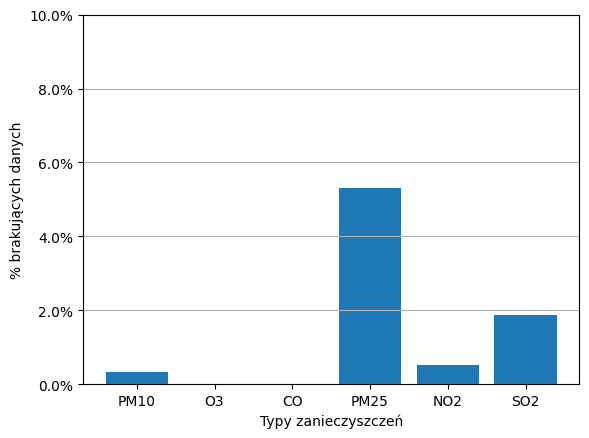

In [83]:
def missing_data_plots(missing_data_dict: dict):
    x = list(missing_data_dict.keys())
    y = [round(data_miss / data_size * 100, 2) for (data_miss, data_size) in missing_data_dict.values()]
    plt.bar(x, y)
    plt.xlabel('Typy zanieczyszczeń')
    plt.ylabel('% brakujących danych')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100))
    ax.yaxis.grid(True)
    plt.ylim(0, 10)
    # plt.show()
    plt.savefig('missing_data.png')
    
missing_data_plots(missing_data)

In [ ]:
def plot_compare() -> None:
    fig, [ax1, ax2, ax3] = plt.subplots(ncols=3,figsize=(15,5))
    for metric,name,ax in zip([mean_squared_error,mean_absolute_error,r2_score],['MSE','MAE','R2'],[ax1,ax2,ax3]):
        y_pred_forest = forest_model.predict(x_test)
        y_pred_gradient = gradient_model.predict(x_test)
        y_pred_ridge = ridge_model.predict(x_test)
        y_values = [metric(y_test,y_pred_forest),metric(y_test,y_pred_gradient),metric(y_test,y_pred_ridge)]
        sns.barplot(x=['Random Forest Regressor','Gradient Boosting Regressor','Ridge'],y=y_values,hue=y_values,palette=('RdYlGn_r' if name!="R2" else 'RdYlGn') ,ax=ax)
        ax.set_ylabel('value')
        ax.set_title(f'{name} comparison')
        for i in ax.containers:
            ax.bar_label(i,fmt='%.2f',label_type='edge')
        ax.legend().remove()
        ax.xaxis.set_tick_params(rotation=45)
plot_compare()